# PROJECT : Twitter Sentiment Analysis 

## Introduction
### Natural Language Processing (NLP): 
- The discipline of computer science, artificial intelligence and linguistics that is concerned with the creation of computational models that process and understand natural language. These include: making the computer understand the semantic grouping of words (e.g. cat and dog are semantically more similar than cat and spoon), text to speech, language translation and many more

### Sentiment Analysis: 
- It is the interpretation and classification of emotions (positive, negative and neutral) within text data using text analysis techniques. Sentiment analysis allows organizations to identify public sentiment towards certain words or topics.

In this notebook, we will develop a Sentiment Analysis model to categorize a tweet as Positive or Negative.

In [2]:
#import libraries we need

# utilities
import re
import pickle
import numpy as np
import pandas as pd

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# nltk
import nltk
from nltk.stem import WordNetLemmatizer


# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB

nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Gatsu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Gatsu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# CHAP 0 : Data set information :
The dataset being used is the sentiment140 dataset. It contains 1,600,000 tweets extracted using the Twitter API. The tweets have been annotated (0 = Negative, 4 = Positive) and they can be used to detect sentiment.

**note :**
*The training data isn't perfectly categorised as it has been created by tagging the text according to the emoji present. So, any model built using this dataset may have lower than expected accuracy, since the dataset isn't perfectly categorised*

It contains the following 6 fields:

- **sentiment:** the polarity of the tweet (0 = negative, 4 = positive)
- **ids:** The id of the tweet (2087)
- **date:** the date of the tweet (Sat May 16 23:58:44 UTC 2009)
- **flag:** The query (lyx). If there is no query, then this value is NO_QUERY.
- **user:** the user that tweeted (robotickilldozr)
- **text:** the text of the tweet (Lyx is cool)

We require only the sentiment and text fields, so we discard the rest.
Furthermore, we're changing the sentiment field so that it has new values to reflect the sentiment. (1 = Negative, 0 = Positive)

In [3]:
# Importing the dataset
df_col  = ["sentiment", "ids", "date", "flag", "user", "text"]
df_encod = "ISO-8859-1"
dataset = pd.read_csv(r'C:\Users\Gatsu\Desktop\Python\NLP project\training.1600000.processed.noemoticon.csv', encoding=df_encod , names=df_col)

In [4]:
# Removing the unnecessary columns.
dataset = dataset[['sentiment','text']] #keep only the variable we need for our analysis

In [5]:
# Replacing the values to ease understanding.
dataset['sentiment'] = dataset['sentiment'].replace({0: 1, 4: 0})

In [6]:
#Value counts sentiment
dataset['sentiment'].value_counts()

sentiment
1    800000
0    800000
Name: count, dtype: int64

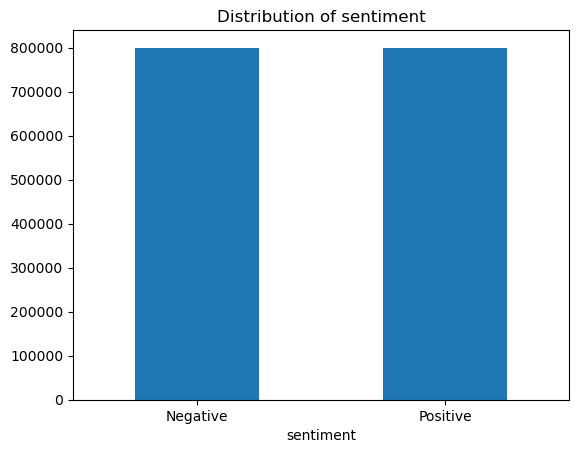

In [7]:
# Plotting the distribution for dataset.
ax = dataset.groupby('sentiment').count().plot(kind='bar', title='Distribution of sentiment', legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)

# Storing data in lists.
text, sentiment = list(dataset['text']), list(dataset['sentiment'])

# CHAP 1 : PRE-PROCESSING

Text Preprocessing is an important step for Natural Language Processing (NLP) tasks. It transforms text into a more digestible form so that machine learning algorithms can perform better.

The Preprocessing steps taken are:

- **Lower Casing**: Each text is converted to lowercase.
- **Replacing Emojis:** Replace emojis by using a pre-defined dictionary containing emojis along with their meaning. (eg: ":)" to "EMOJIsmile")
- **Removing Usernames:** Remove @Usernames 
- **Removing URLs**: Links starting with "http" or "https" or "www" are removed.
- **Removing Non-Alphabets:** Replacing characters except (Digits and Alphabets) with a space.
- **Removing Consecutive letters:** 3 or more consecutive letters are replaced by 2 letters. (eg: "Heyyyy" to "Heyy")
- **Removing Short Words:** Words with length less than 2 are removed.
- **Removing Stopwords:** Stopwords are the English words which does not add much meaning to a sentence. They can safely be ignored without sacrificing the meaning of the sentence. (eg: "the", "he", "have")
- **Lemmatizing**: Lemmatization is the process of converting a word to its base form. (e.g: “Great” to “Good”)

In [8]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

## Defining set containing all stopwords in english.
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', 'u', 'b', 'v', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [9]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stopwordlist = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(tweet):
    # Lowercase the text
    tweet = tweet.lower()

    # Remove URLs
    tweet = re.sub(r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)", '', tweet, flags=re.MULTILINE)
    
    # Remove usernames
    tweet = re.sub(r'@[\w]*', '', tweet, flags=re.MULTILINE)

    # Replace emojis
    def replace_emojis(word):
        return emojis.get(word, word)
    tweet = ' '.join(replace_emojis(word) for word in tweet.split())

    # Remove hashtags
    tweet = re.sub(r'#[\w]*', '', tweet, flags=re.MULTILINE)

    # Replace 3 or more consecutive letters by 2 letters
    tweet = re.sub(r"(.)\1\1+", r"\1\1", tweet, flags=re.MULTILINE)
    
    # Replace non-alphabetic characters
    tweet = re.sub("[^a-zA-Z0-9]", ' ', tweet, flags=re.MULTILINE)

    # Remove custom stopwords
    def remove_custom_stopwords(text):
        words = text.split()
        filtered_words = [word for word in words if word.lower() not in stopwordlist]
        return ' '.join(filtered_words)
    tweet = remove_custom_stopwords(tweet)

    # Remove short words
    tweet = ' '.join([word for word in tweet.split() if len(word) >= 2])

    # Lemmatize text
    def lemmatize_text(text):
        words = text.split()
        lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
        return ' '.join(lemmatized_words)
    tweet = lemmatize_text(tweet)

    return tweet

In [10]:
# apply preprocess
dataset['PreprocessedText'] = dataset['text'].apply(preprocess_text)
dataset.head()

,sentiment,text,PreprocessedText
0,1,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",aww bummer shoulda got david carr third day wink
1,1,is upset that he can't update his Facebook by ...,upset update facebook texting might cry result...
2,1,@Kenichan I dived many times for the ball. Man...,dived many time ball managed save 50 rest go b...
3,1,my whole body feels itchy and like its on fire,whole body feel itchy like fire
4,1,"@nationwideclass no, it's not behaving at all....",behaving mad see


# 1. Cloud Words

## 1.1 Cloud Words for negative tweet

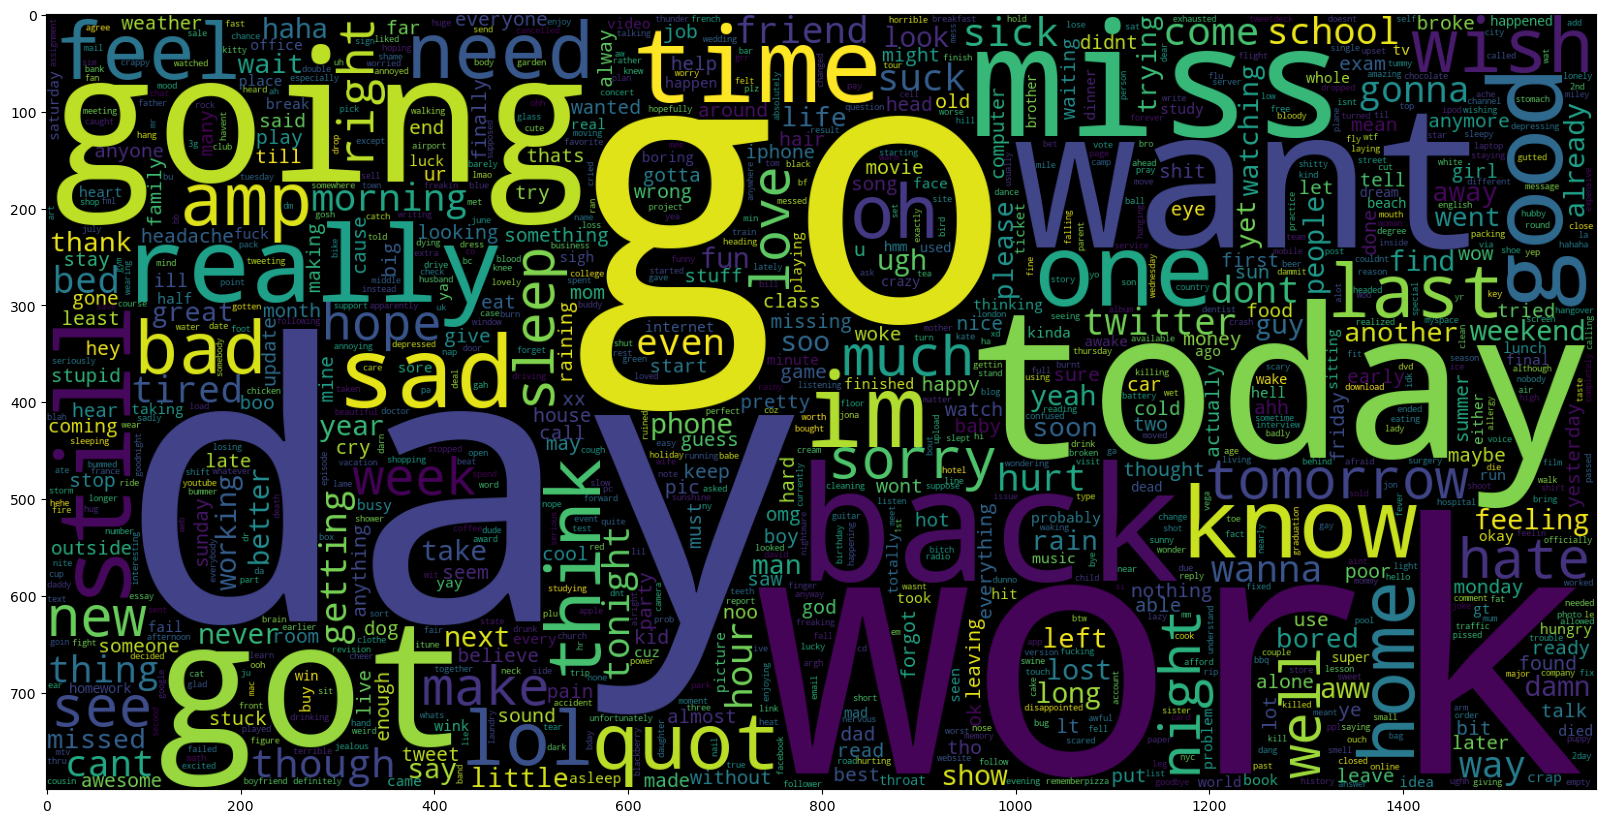

In [11]:
data_neg = dataset[dataset['sentiment']==1]

plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg['PreprocessedText']))
plt.imshow(wc)

## 1.2 Cloud Word for positive tweet

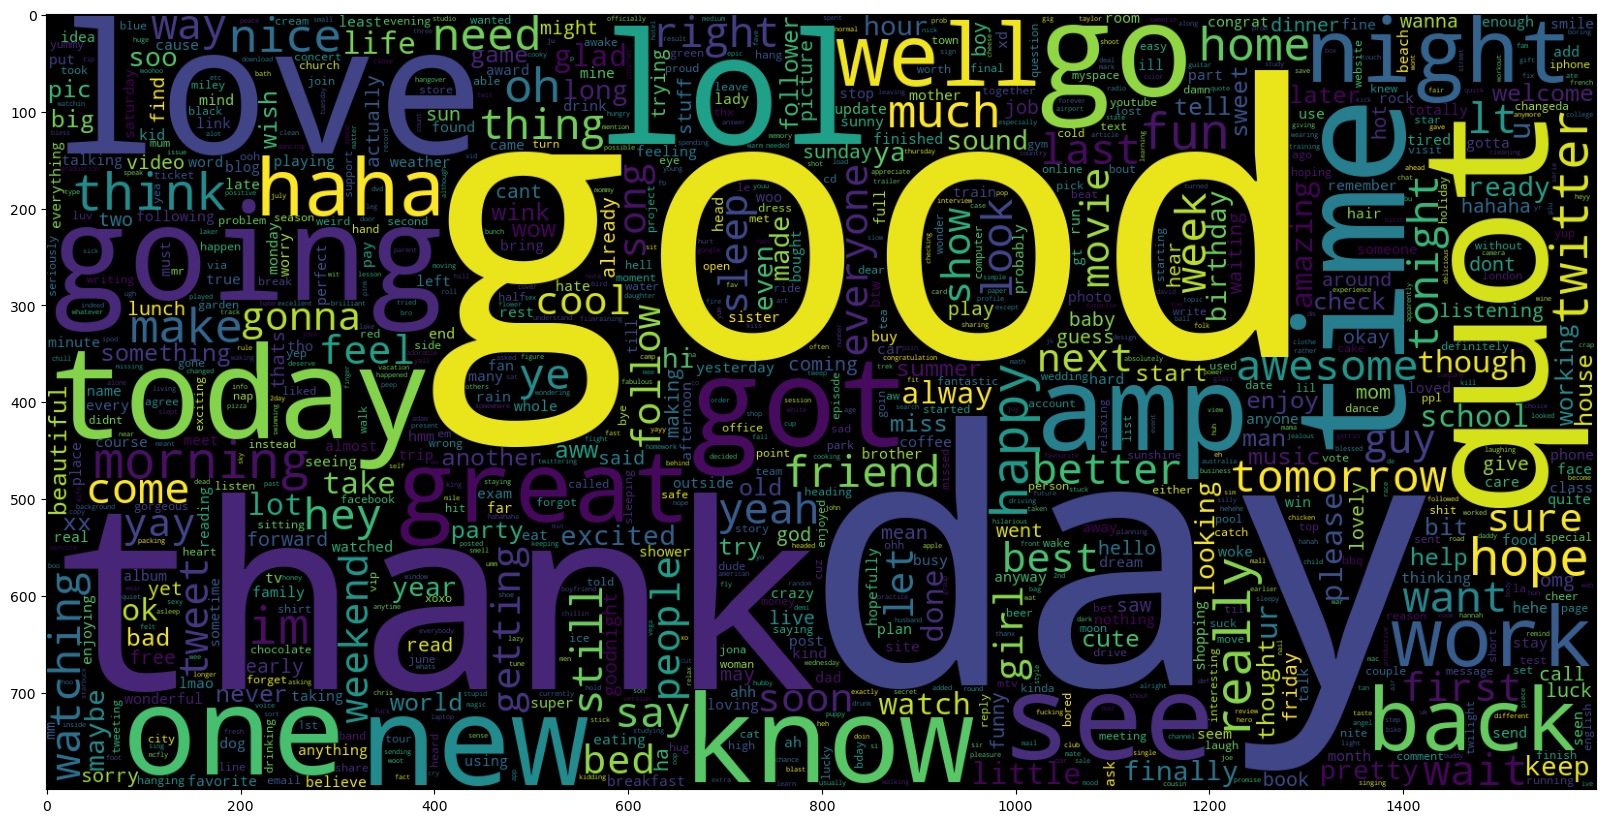

In [12]:
data_pos = dataset[dataset['sentiment']==0]

plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_pos['PreprocessedText']))
plt.imshow(wc)

# CHAP 3 : MODELISATION

- Lets split our data into training & test
- Vectorize our data
- find the best model & hyperparameters
- evaluate the model

In [13]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(dataset['PreprocessedText'],
                                                    dataset['sentiment'],
                                                    test_size=0.2,
                                                    random_state=42)

In [14]:
# Vectorizing the training and testing sets separately
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

Model: Naive Bayes
Best Parameters: {'alpha': 1.0}
Accuracy: 0.7670, Recall: 0.7780, F1 Score: 0.7690


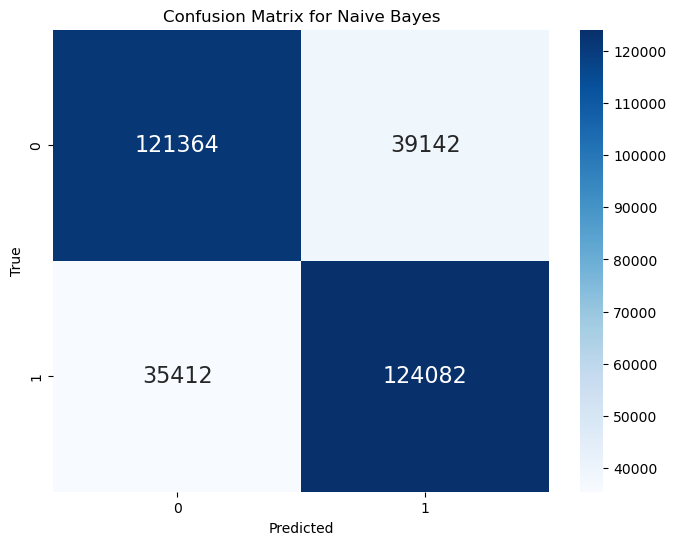

In [15]:
# Define the models and their respective parameter grids
models = [
    {
        'name': 'Naive Bayes',
        'estimator': MultinomialNB(),
        'param_grid': {'alpha': [0.1, 0.5, 1.0]}
    }
]

# Loop through each model, perform grid search, and evaluate
for model in models:
    grid_search = GridSearchCV(estimator=model['estimator'], param_grid=model['param_grid'], cv=5, scoring='accuracy')
    grid_search.fit(X_train_vectorized, y_train)
    
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_
    
    # Evaluate on test set
    y_pred = best_model.predict(X_test_vectorized)
    
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"Model: {model['name']}")
    print(f"Best Parameters: {best_params}")
    print(f"Accuracy: {accuracy:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', annot_kws={"size": 16})
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f"Confusion Matrix for {model['name']}")
    plt.show()

# CHAP 4 : Testing model

Here, we gonna define a function that gonna use our model to predict the sentiment of random tweet to see how our model perform 

In [16]:
def predict_sentiment(text, vectorizer, model):
    # Preprocess the text
    preprocessed_text = preprocess_text(text)  # Assuming you have your preprocess_text function defined

    # Transform the preprocessed text using the provided vectorizer
    text_vectorized = vectorizer.transform([preprocessed_text])

    # Predict sentiment using your model
    predicted_sentiment = model.predict(text_vectorized)[0]  # Replace model.predict with your model's prediction method

    # Return the predicted sentiment
    return predicted_sentiment

In [17]:
# List of random tweets
random_tweets = [
    "Just had the worst day ever! 😞 #terrible",
    "Loving the new updates! Great job team! 👍 #awesome",
    "Rainy days make me feel cozy and nostalgic. #rainyday",
    "Stuck in traffic again. This is frustrating! 🚗 #traffic",
    "Excited for the weekend plans! Can't wait to relax. 😊 #weekendvibes"
]

# Loop through the random tweets and predict sentiment
for tweet in random_tweets:
    predicted_sentiment = predict_sentiment(tweet, vectorizer, best_model)
    print(f"Tweet: {tweet}")
    print(f"Predicted sentiment: {predicted_sentiment}")
    print("=" * 40)

Tweet: Just had the worst day ever! 😞 #terrible
Predicted sentiment: 1
Tweet: Loving the new updates! Great job team! 👍 #awesome
Predicted sentiment: 0
Tweet: Rainy days make me feel cozy and nostalgic. #rainyday
Predicted sentiment: 1
Tweet: Stuck in traffic again. This is frustrating! 🚗 #traffic
Predicted sentiment: 1
Tweet: Excited for the weekend plans! Can't wait to relax. 😊 #weekendvibes
Predicted sentiment: 0


In [18]:
# List of random tweets (including some with sarcasm)
random_tweets = [
    "Just won the lottery! Oh joy, more taxes to pay! 🙄💸 #sarcasm",
    "Wow, another Monday. Can't wait for this amazing day! 🙃 #notreally",
    "Oh sure, because getting up at 5 am is everyone's idea of fun! 😑 #sarcasm",
    "Fantastic, another meeting about a meeting. How productive! 😒 #sarcastic",
    "Oh, great, another flat tire. My day is just perfect! 🙄🚗 #notreally",
    "Sure, I'll just add more tasks to my never-ending to-do list! 😅 #sarcasm",
    "Just what I needed, more spam emails in my inbox! 📧🙄 #sarcastic",
    "Oh, how I adore spending my weekends doing chores! 🧹🤨 #notreally"
]

# Loop through the random tweets and predict sentiment
for tweet in random_tweets:
    predicted_sentiment = predict_sentiment(tweet, vectorizer, best_model)
    print(f"Tweet: {tweet}")
    print(f"Predicted sentiment: {predicted_sentiment}")
    print("=" * 40)

Tweet: Just won the lottery! Oh joy, more taxes to pay! 🙄💸 #sarcasm
Predicted sentiment: 1
Tweet: Wow, another Monday. Can't wait for this amazing day! 🙃 #notreally
Predicted sentiment: 0
Tweet: Oh sure, because getting up at 5 am is everyone's idea of fun! 😑 #sarcasm
Predicted sentiment: 0
Tweet: Fantastic, another meeting about a meeting. How productive! 😒 #sarcastic
Predicted sentiment: 0
Tweet: Oh, great, another flat tire. My day is just perfect! 🙄🚗 #notreally
Predicted sentiment: 0
Tweet: Sure, I'll just add more tasks to my never-ending to-do list! 😅 #sarcasm
Predicted sentiment: 0
Tweet: Just what I needed, more spam emails in my inbox! 📧🙄 #sarcastic
Predicted sentiment: 0
Tweet: Oh, how I adore spending my weekends doing chores! 🧹🤨 #notreally
Predicted sentiment: 0


# Remarque :
- We can see that our model predict good when the tweet is basic, but when whe have sarcasm, it's doesn't work well.